# Predict GPU performance from other GPUs
### Use model trained on training data set from 5 GPUs, test on (all) data from remaining GPU

In [2]:
%matplotlib inline
import os
import sys
import tensorflow as tf
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [3]:
from prediction_model import dataprep

In [4]:
predict = 'QuadroP2000'
data_model = '%s' %predict

prediction_model = '%s' %predict

In [5]:
# Set paths
PREDICTION_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/saved_model' %prediction_model)
SCALER_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/scaler_Conv.save' %prediction_model)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model/data/Data_convolution_%s.pkl' %data_model)

In [6]:
scaler = joblib.load(SCALER_PATH)
df = pd.read_pickle(DATA_PATH)
tfmodel_file = PREDICTION_PATH

In [7]:
df.describe()

batchsize  channels_in  channels_out     gpu   kernelsize  \
count  9383.000000  9383.000000   9383.000000  9383.0  9383.000000   
mean    121.266652    14.333049     14.535863     0.0     3.978791   
std      71.603786    65.871528     64.641642     0.0     2.013088   
min       1.000000     1.000000      1.000000     0.0     1.000000   
25%      59.000000     2.000000      2.000000     0.0     2.000000   
50%     117.000000     4.000000      4.000000     0.0     4.000000   
75%     184.000000     8.000000      8.000000     0.0     6.000000   
max     250.000000  1852.000000   1942.000000     0.0     7.000000   

           matsize      padding  precision      strides  timeUsed_max  ...  \
count  9383.000000  9383.000000     9383.0  9383.000000   9383.000000  ...   
mean    245.620271     0.505595       32.0     2.520729     82.986734  ...   
std     146.825455     0.499995        0.0     1.109047    152.331398  ...   
min       1.000000     0.000000       32.0     1.000000      0.672007  ...   
25%     117.000000     0.000000       32.0     2.000000      7.185888  ...   
50%     242.000000     1.000000       32.0     3.000000     23.942184  ...   
75%     372.000000     1.000000       32.0     4.000000     90.649009  ...   
max     512.000000     1.000000       32.0     4.000000   1677.131987  ...   

       opt_Adagrad     opt_Adam  opt_Momentum     opt_None  opt_RMSProp  \
count  9383.000000  9383.000000   9383.000000  9383.000000  9383.000000   
mean      0.084301     0.078120      0.078973     0.523713     0.076095   
std       0.277854     0.268375      0.269710     0.499464     0.265164   
min       0.000000     0.000000      0.000000     0.000000     0.000000   
25%       0.000000     0.000000      0.000000     0.000000     0.000000   
50%       0.000000     0.000000      0.000000     1.000000     0.000000   
75%       0.000000     0.000000      0.000000     1.000000     0.000000   
max       1.000000     1.000000      1.000000     1.000000     1.000000   

           opt_SGD     act_None     act_relu  act_sigmoid     act_tanh  
count  9383.000000  9383.000000  9383.000000  9383.000000  9383.000000  
mean      0.083769     0.252691     0.253224     0.248961     0.245124  
std       0.277055     0.434578     0.434881     0.432434     0.430184  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     1.000000     1.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 31 columns]

In [10]:
data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
split=[0.8,0.1,.1]

In [11]:
data, time, train, test, validation = dataprep.data_preprocess_keep(df,data_cols_conv,split,scaler)

/home/peter/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: operands could not be broadcast together with shapes (9383,20) (17,) (9383,20) 

INFO:tensorflow:Restoring parameters from /Users/djustus/workspace/newcastle/ml-performance-prediction/prediction_model/models/no_V100/saved_model/variables/variables


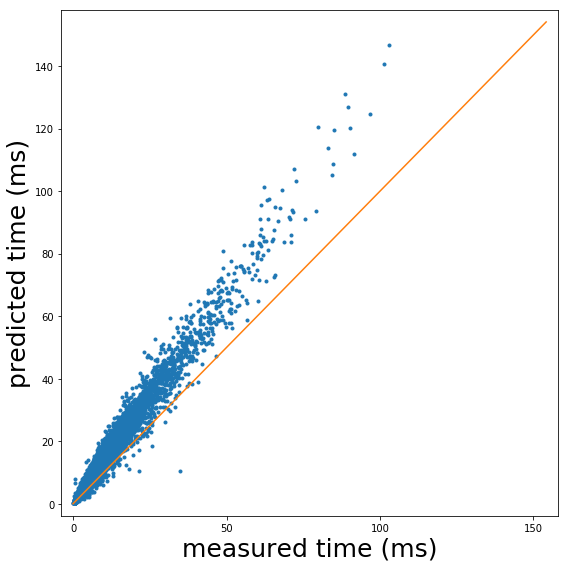

In [10]:
with tf.Session() as sess:
    tf.saved_model.loader.load(sess, ["serve"], tfmodel_file)
    graph = tf.get_default_graph()


    run = sess.run(
            'model_prediction:0',
            feed_dict={'model_input:0': data['Validation'], 
                       'model_targets:0': time['Validation'],
                       'model_istraining:0': False})
RMS_validation_error=np.sqrt(np.mean((time['Validation']-run)**2))
perc_error = np.mean(np.abs(time['Validation']-run)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],run,'.')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 

plt.xlabel('measured time (ms)',fontsize=25)
plt.ylabel('predicted time (ms)',fontsize=25)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()
ax.ticklabel_format(useOffset=False)
ax.plot([0,axlim],[0,axlim],2)

#plt.savefig('figures/prediction_%s_from_other.png' %predict, dpi=300)

plt.show()

In [11]:
RMS_validation_error

3.6470957

In [12]:
perc_error

39.57671523094177